# 1/2Q gates on two coupled fixed transmons with parametric charge-charge coupling

In this notebook, we consider a system of two fixed frequency transmons with a coupling via the charge operator (corresponds to dipole-dipole capacitive coupling). We assume that we can apply a paramteric drive on the coupling term. We will show single qubit gates and also tune up a CZ on this system and show that it's quite sensitive to static ZZ coupling.

The Hamiltonian of the system is:

$$
H = E_{c1}(\hat{n}_1 -n_{g1})^2 - E_{J1}\cos(\hat{\phi}_1) + E_{c2}(\hat{n}_1 -n_{g2})^2 - E_{J2}\cos(\hat{\phi}_2) \\
+ g_1 v_{d1}(t) \hat{n}_1  + g_2 v_{d2}(t) \hat{n}_2  \\
+ g_{12}(1+v_{p}(t))\hat{n}_1\hat{n}_2.
$$

Here $\hat{n}_i$ are operators for the number of Cooper pairs on the transmon island, $\hat{\phi}_i$ are operators for the phase across the JJ, $v_{di}$ are (normalized) single qubit drive pulses, and $v_{p}$ is a paramteric drive pulse.

The first question we would like to answer is how can we see that we obtain here the interaction we want in order to perform a CZ. In order to answer this, let's look at the $\hat{n}_1\hat{n}_2$ in the energy eigenbasis. As we will see, in this basis the number operators couple between states whose index defer by one, so each number operator looks roughly like this:

$$
\hat{n}_i \simeq \ket{0}\bra{1} + \ket{1}\bra{2} + \dots + \rm{h.c}
$$

so the combined operator will have the following terms:

$$
\hat{n}_1\hat{n}_2 \simeq \ket{00}\bra{11} + \ket{01}\bra{10} + \ket{02}\bra{11} + \dots + \rm{h.c}
$$

The two most interesting terms are $\ket{01}\bra{10}$ that provides an iSWAP interaction, and $ \ket{02}\bra{11} + \rm{h.c}$ that provides a CZ interaction.

In the frame rotating with the dressed qubit energies, these terms will oscillate, and the interaction term will look like this:

$$
g_{12}(1+v_{p})(t)(\ket{02}\ket{11}\exp(-i(\omega_{02} - \omega_{11})t) + \rm{h.c}),
$$

and so we will need a paramteric drive at the corresponding $\omega_{02} - \omega_{11}$ frequency to be on resonance with this interaction. This is what we show in what follows.

## Choosing the qubit parameters

1. need to make sure 11 and 02/20 are not too close
2. need to make sure that g is not too big which can make the static ZZ coupling very large
3. need to make sure that the qubits are far enough in frequency so that static ZZ is not too large

In [1]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt
from qutip.qip.operations import rz, cz_gate
import cmath


def generate_hilbertspace(EJ1, EC1, EJ2, EC2, g_strength):
    tmon1 = scq.Transmon(
        EJ=EJ1,
        EC=EC1,
        ng=0.0,
        ncut=31,
        truncated_dim=3

    )

    tmon2 = scq.Transmon(
        EJ=EJ2,
        EC=EC2,
        ng=0.0,
        ncut=31,
        truncated_dim=3
    )

    # define the common Hilbert space
    hilbertspace = scq.HilbertSpace([tmon1, tmon2])

    # add interaction between two qubits
    hilbertspace.add_interaction(
        g_strength=g_strength,
        op1=tmon1.n_operator,
        op2=tmon2.n_operator,
    )

    # generate spectrum lookup table
    hilbertspace.generate_lookup()
    return tmon1, tmon2, hilbertspace


g_strength = 0.02
tmon1, tmon2, hilbertspace = generate_hilbertspace(21, 0.25, 25, 0.25, g_strength)

bare_indices = [hilbertspace.bare_index(i) for i in range(9)]
qutip_indices = [(i1, i2) for i1 in range(3) for i2 in range(3)]

 /Users/lior/git/scqubits-examples/.conda/lib/python3.10/site-packages/qutip/__init__.py: 66

## Diagonalization, energy level diagram

We first focus on the static part of the Hamlitonian, namely

$$
H = E_{c1}(\hat{n}_1 -n_{g1})^2 - E_{J1}\cos(\hat{\phi}_1) + E_{c2}(\hat{n}_1 -n_{g2})^2 - E_{J2}\cos(\hat{\phi}_2) \\
+ g_{12}\hat{n}_1\hat{n}_2.
$$

We plot the energy levels ladder. We show both the dressed energies as well as the bare energies and compare them. We zoom in on the 11/02/20 region because this is where most shifts from the static occur, and also importantly it shows the static ZZ shift.

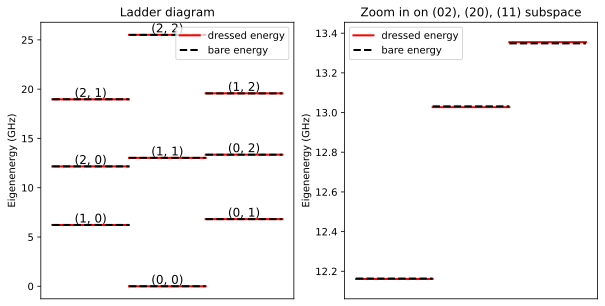

In [2]:
energies = hilbertspace.eigenvals(evals_count=hilbertspace.dimension)
ground_energy = hilbertspace.eigenvals(evals_count=1)[0]

bare_energies = [e1 + e2 for e1 in tmon1.eigenvals(evals_count=3) for e2 in tmon2.eigenvals(evals_count=3)]
ground_energy_bare = bare_energies[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(hilbertspace.dimension):
    bare_ind = hilbertspace.bare_index(i)

    energy = energies[i] - ground_energy
    horizontal_pos = 2*np.argmax(bare_ind) if bare_ind[0] != bare_ind[1] else 1
    label = 'dressed energy' if i == 0 else None
    for ax in axes:
        ax.plot([horizontal_pos, horizontal_pos + 1], [energy, energy], color='r', lw=2, label=label)
    axes[0].text(horizontal_pos+0.5, energy, f"{bare_ind}", ha='center', va='bottom', fontsize=12)

for i in range(hilbertspace.dimension):
    qutip_ind = qutip_indices[i]
    energy_bare = bare_energies[i] - ground_energy_bare
    horizontal_pos = 2*np.argmax(qutip_ind) if qutip_ind[0] != qutip_ind[1] else 1
    label = 'bare energy' if i == 0 else None
    for ax in axes:
        ax.plot([horizontal_pos, horizontal_pos + 1], [energy_bare, energy_bare], 'k--', lw=2, label=label)

        ax.set_xticks([])
        ax.set_ylabel('Eigenenergy (GHz)')
        ax.legend()
    axes[0].set_title('Ladder diagram')
    lim_energies = np.array([hilbertspace.energy_by_bare_index(bare_ind) for bare_ind in [(0, 2), (2, 0), (1, 1)]]) - ground_energy
    axes[1].set_ylim(min(lim_energies) - 0.1, max(lim_energies) + 0.1)
    axes[1].set_title('Zoom in on (02), (20), (11) subspace')


### Summary of transmon system parameters

here we show both the bare and dressed energies and look at the difference between them, and static ZZ.

In [3]:
def summarize_parameters(tmon1, tmon2, hilbertspace):
    print('bare parameters\n----------------')
    print(f'tmon1 anharmonicity = {tmon1.anharmonicity():.4f} GHz')
    print(f'tmon2 anharmonicity = {tmon2.anharmonicity():.4f} GHz')
    print(f'tmon1 E01 = {tmon1.E01():.4f} GHz')
    print(f'tmon2 E01 = {tmon2.E01():.4f} GHz')
    print(f'tmon1 E01 - tmon2 E01 = {tmon2.E01() - tmon1.E01():.4f} GHz')

    print(f'\ndressed parameters (g = {g_strength*1e3:.2f} MHz)\n------------------------------')
    f00_10 = hilbertspace.energy_by_bare_index((1, 0)) - hilbertspace.energy_by_bare_index((0, 0))
    print(f'{f00_10=:.3f} GHz')
    f00_01 = hilbertspace.energy_by_bare_index((0, 1)) - hilbertspace.energy_by_bare_index((0, 0))
    print(f'{f00_01=:.3f} GHz')
    f11_20 = hilbertspace.energy_by_bare_index((2, 0)) - hilbertspace.energy_by_bare_index((1, 1))
    print(f'{f11_20=:.3f} GHz')
    f11_02 = hilbertspace.energy_by_bare_index((0, 2)) - hilbertspace.energy_by_bare_index((1, 1))
    print(f'{f11_02=:.3f} GHz')
    static_ZZ = hilbertspace.energy_by_bare_index((1, 1)) - hilbertspace.energy_by_bare_index((0, 1)) - hilbertspace.energy_by_bare_index((1, 0)) + hilbertspace.energy_by_bare_index((0, 0))
    print(f'static ZZ = {static_ZZ*1e3:.6f} MHz')
    print(f'E10 shift = {1e3*(tmon1.E01() - f00_10):.4f} MHz')
    print(f'E01 shift = {1e3*(tmon2.E01() - f00_01):.4f} MHz')

summarize_parameters(tmon1, tmon2, hilbertspace)


bare parameters
----------------
tmon1 anharmonicity = -0.2766 GHz
tmon2 anharmonicity = -0.2739 GHz
tmon1 E01 = 6.2200 GHz
tmon2 E01 = 6.8113 GHz
tmon1 E01 - tmon2 E01 = 0.5913 GHz

dressed parameters (g = 20.00 MHz)
------------------------------
f00_10=6.218 GHz
f00_01=6.813 GHz
f11_20=-0.866 GHz
f11_02=0.328 GHz
static ZZ = -3.967074 MHz
E10 shift = 1.8623 MHz
E01 shift = -1.7070 MHz


In [4]:
# TODO: look at static ZZ vs. g_strength and vs. EJ1, EJ2

## Eigenstates, operators in the dressed basis

Below we plot the weight of the bare states in the dressed state, indexed by the original bare states. We can see that bevcause 02 and 11 are so close, we will get a significant weight of one in the other. For other states it's not the case.

In [5]:
# permutations of the bare and dressed indices
dressed_to_qutip = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in qutip_indices] 
qutip_to_dressed = [dressed_to_qutip.index(i) for i in range(9)]

We first plot the transformation matrix from the dressed to the bare eigenstates. We see that the dressed eigenstates hybridize some of the bare states. Specifically, the 01 and 10 sector, the 02, 11, 20 sector and the 12, 21 sector. This makes sense, since as we see in the energy ladder diagram, they are the closest to each other.

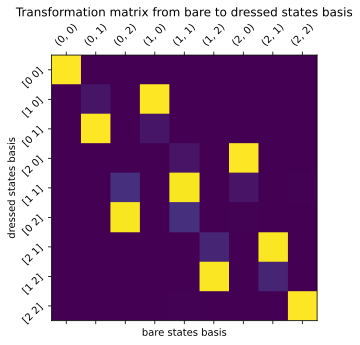

In [6]:
eigs = hilbertspace.eigensys(evals_count=9)[1]
tmat = [eigs[i].full() for i in range(9)]
tmat = np.squeeze(tmat)
tmat = qt.Qobj(tmat, dims=[[3, 3], [3, 3]])
tmat

fig, ax = plt.subplots()
ax.matshow(np.abs(tmat.full()))
ax.set_xticks(range(9))
ax.set_xticklabels(qutip_indices, rotation=45)
ax.set_xlabel('bare states basis')
ax.set_yticks(range(9))
ax.set_yticklabels(np.array(qutip_indices)[qutip_to_dressed], rotation=45)
ax.set_title('Transformation matrix from bare to dressed states basis')
ax.set_ylabel('dressed states basis');

We now obtain the drive operators, $\hat{n}_1$, $\hat{n}_2$ and $\hat{n}_1\hat{n}_2$ in the dressed state eigenbasis.

We then plot their matrix elements.

We can see that as we can predict, $\hat{n}_i$ behave mainly like $a+a^\dagger$ operators in their respective single qubit basis. The static coupling term also shows that they hybridize to some extent with the number operators of the other qubit. We also see that they have a strictly odd parity, only coupling states that differ in one photon excitation.

Furthermore, we see that $\hat{n}_1\hat{n}_2$ is an even operator that only couples states that differ by two photons. This includes couplings that we care about, such as $\ket{02}\bra{11}$, $\ket{01}\bra{10}$, but also others we don't want. We denote the different sectors using red dashed lines.

In [7]:
def generate_interaction_terms(tmon1, tmon2, hilbertspace, g_strength):
    # get the representation of the n_1, n_2, interaction operators in the dressed eigenbasis of the composite system
    # note that these are in the dressed basis
    n_1 = hilbertspace.op_in_dressed_eigenbasis(op=tmon1.n_operator)  
    n_2 = hilbertspace.op_in_dressed_eigenbasis(op=tmon2.n_operator) 

    # this is given in the bare basis, and we need to transform it to the dressed basis
    
    interaction_term = g_strength*n_1*n_2

    return n_1, n_2, interaction_term

n_1, n_2, interaction_term = generate_interaction_terms(tmon1, tmon2, hilbertspace, g_strength)

# note that equivalently we could have just defined it explicitly using the transformation matrix
interaction_term = hilbertspace.interaction_hamiltonian()  
interaction_term = tmat * interaction_term * tmat.dag()
assert np.max(np.abs((g_strength*n_1*n_2 - interaction_term).full())) < 1e-16


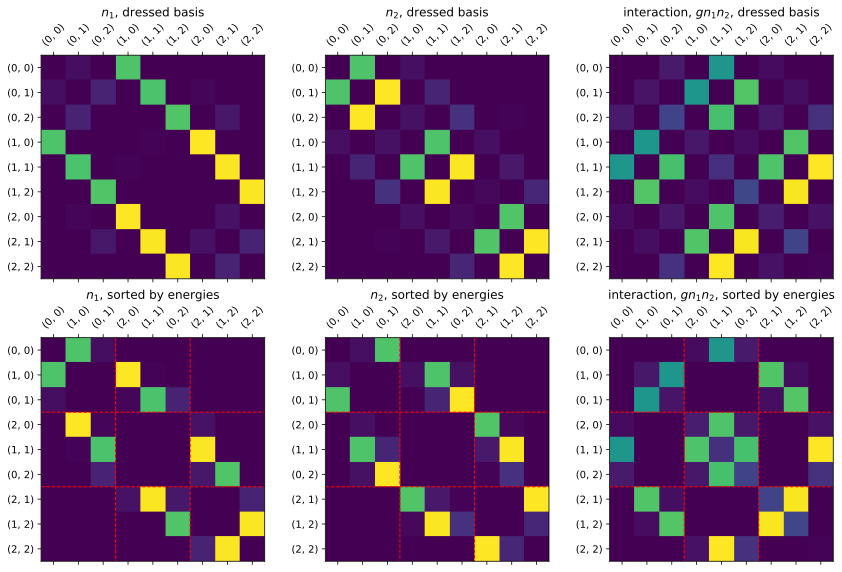

In [8]:
indices = qutip_indices
# plot n_1, n_2 as a matrix plot, with indices given by the qutip indices

fig, axes_grid = plt.subplots(2, 3, figsize=(12, 8))

mat_to_plot = [np.abs(n_1.full()), np.abs(n_2.full()), np.abs(interaction_term.full())]

axes = axes_grid[0]
for ax, mat in zip(axes, mat_to_plot):
    mat = mat[dressed_to_qutip, :]
    mat = mat[:, dressed_to_qutip]
    ax.matshow(mat)
    ax.set_xticks(range(9))
    ax.set_xticklabels(indices, rotation=45)
    ax.set_yticks(range(9))
    ax.set_yticklabels(indices)

axes[0].set_title(r'$n_1$, dressed basis')
axes[1].set_title(r'$n_2$, dressed basis')
axes[2].set_title(r'interaction, $gn_1n_2$, dressed basis')

indices = bare_indices
axes = axes_grid[1]
# plot n_1, n_2 as a matrix plot, with indices given by the qutip indices

mat_to_plot = [np.abs(n_1.full()), np.abs(n_2.full()), np.abs(interaction_term.full())]

for ax, mat in zip(axes, mat_to_plot):
    ax.matshow(mat)
    ax.plot([2.5, 2.5], [-0.5, 8.5], 'r--', lw=1)
    ax.plot([-0.5, 8.5], [2.5, 2.5], 'r--', lw=1)
    ax.plot([5.5, 5.5], [-0.5, 8.5], 'r--', lw=1)
    ax.plot([-0.5, 8.5], [5.5, 5.5], 'r--', lw=1)
    ax.set_xticks(range(9))
    ax.set_xticklabels(indices, rotation=45)
    ax.set_yticks(range(9))
    ax.set_yticklabels(indices)

axes[0].set_title(r'$n_1$, sorted by energies')
axes[1].set_title(r'$n_2$, sorted by energies')
axes[2].set_title(r'interaction, $gn_1n_2$, sorted by energies')

fig.tight_layout()

## Driving the qubits to generate gates

We look at gate evolution by calculating the propagator between two states of interest, $\ket{s}$ and $\ket{f}$:

$$
\bra{f}U\ket{s} = \bra{f}e^{-i\int_0^{t_g} dt'(H_0 + H_i(t'))}\ket{s}
$$

Focusing on the interacting part, we see that it is given by:

$\bra{f}\exp(-i\hat{X}\int_0^{t_g} dt'v(t'))\ket{s}$

where $\hat{X}$ is the relevant drive operator, $t_g$ is the gate duration, and $v(t')$ is the drive pulse.

In order to make the procedure more robust, we calculate the drive amplitude by taking a first order approximation:

$\bra{f}\exp(-i\hat{X}\int_0^{t_g} dt'v(t'))\ket{s} \simeq \exp(-i\bra{f}\hat{X}\ket{s}\int_0^{t_g} dt'v(t')) $

if we further define $v(t) = Au(t)$ where $u(t)$ is normalized: $\int_0^{t_g} dt'u(t')=t_g$, we find that

$$
A = \frac{1}{t_g|\bra{f}\hat{X}\ket{s}|}.
$$

In what follows we use this and a normalized Gaussian drive to get the dynamics for a given gate duration $t_g$.

In [9]:
states = [qt.basis(hilbertspace.dimension, idx) for idx in dressed_to_qutip]

# The computational subspace is spanned by the first 4 states
computational_subspace = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in [(0, 0), (1, 0), (0, 1), (1, 1)]]


def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_bare_index(s1)
            - hilbertspace.energy_by_bare_index(s0)
        )
        * 2
        * np.pi
    )


def get_drive_hamiltonian(drive_term, transitions, tg, rot_angle, detuning=0, verbose=False):
    """ 
    Returns the time-dependent Hamiltonian for driving a transition between two states in the dressed basis.
    The drive term needs to be in the dressed basis.
    """

    omega_drive = transition_frequency(*transitions)

    A = 1 / tg / np.abs(drive_term[bare_indices.index(transitions[0]), bare_indices.index(transitions[1])])
    if verbose:
        print(f'drive freq = {omega_drive/(2*np.pi):.4f} GHz')
        print(f'first order Rabi rate (A) = {A:.3f}')
        print(f'{tg=:.3f} ns')

    #Gaussian pulse envelope
    def drive_coeff(t: float, args: dict) -> float:
        if 0 < t and t < 2*tg:
            return A * np.exp(-8 * (t - tg)**2 / tg**2) / (0.5*np.sqrt(np.pi/2)) * np.cos((omega_drive + detuning) * t)
            # return A * np.cos(omega_drive * t)
        else:
            return 0

    # Hamiltonian in dressed eigenbasis
    (evals,) = hilbertspace["evals"]
    # The factor of 2pi converts the energy to GHz so that the time is in units of ns
    diag_dressed_hamiltonian = (
            2 * np.pi * qt.Qobj(np.diag(evals),
            dims=[hilbertspace.subsystem_dims] * 2)
    )

    # time-dependent drive Hamiltonian
    H_qbt_drive = [
        diag_dressed_hamiltonian,
        [rot_angle*drive_term, drive_coeff],  # driving through the resonator
    ]
    return H_qbt_drive



## Drive Visualization

### single qubit drive on q1

drive freq = 6.2181 GHz
first order Rabi rate (A) = 0.080
tg=10.000 ns


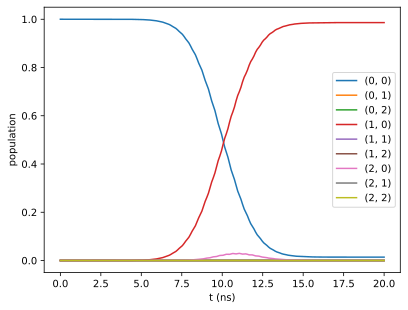

In [10]:
from qutip.solver import Options

drive_term = n_1
transitions = [(0, 0), (1, 0)]
tg = 10  # ns

H_qbt_drive = get_drive_hamiltonian(drive_term, transitions, tg, rot_angle=np.pi, verbose=True)

# array of time list
tlist = np.linspace(0, 2*tg, 200)  # total time

# This simulation is just for viewing the affect of the pulse
result = qt.sesolve(
    H_qbt_drive,
    states[0],
    tlist,
    e_ops=[state * state.dag() for state in states],
    options=Options(nsteps=10000)
)

for idx, res in zip(dressed_to_qutip, result.expect):
    plt.plot(tlist, res, label=hilbertspace.bare_index(idx))

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)");

### single qubit drive on q2

drive freq = 6.8130 GHz
first order Rabi rate (A) = 0.077
tg=10.000 ns


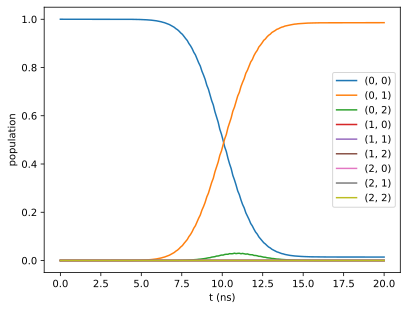

In [11]:
from qutip.solver import Options

drive_term = n_2
transitions = [(0, 0), (0, 1)]
tg = 10  # ns

H_qbt_drive = get_drive_hamiltonian(drive_term, transitions, tg, rot_angle=np.pi, verbose=True)

# array of time list
tlist = np.linspace(0, 2*tg, 200)  # total time

# This simulation is just for viewing the affect of the pulse
result = qt.sesolve(
    H_qbt_drive,
    states[0],
    tlist,
    e_ops=[state * state.dag() for state in states],
    options=Options(nsteps=10000)
)

for idx, res in zip(dressed_to_qutip, result.expect):
    plt.plot(tlist, res, label=hilbertspace.bare_index(idx))

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)");

### CZ gate: 11 through 02

drive freq = 0.3280 GHz
first order Rabi rate (A) = 0.228
tg=100.000 ns


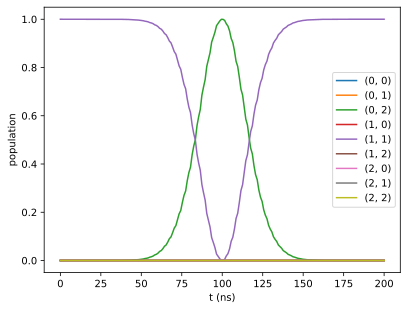

In [12]:
from qutip.solver import Options

drive_term = interaction_term
transitions = [(1, 1), (0, 2)]
tg = 100  # ns

H_qbt_drive = get_drive_hamiltonian(drive_term, transitions, tg, rot_angle=2*np.pi, detuning=0, verbose=True)

# array of time list
tlist = np.linspace(0, 2*tg, 200)  # total time

# This simulation is just for viewing the affect of the pulse
result = qt.sesolve(
    H_qbt_drive,
    states[4],
    tlist,
    e_ops=[state * state.dag() for state in states],
    options=Options(nsteps=10000)
)

for idx, res in zip(dressed_to_qutip, result.expect):
    plt.plot(tlist, res, label=hilbertspace.bare_index(idx))

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)");

## Propagator calculation for CZ

In this section we calculate the actual unitary we apply when we apply the CZ interaction.

We first try this with the large coupling shown above. We will see that the static ZZ is large and that it's hard to find a pulse time for which leakage is low.

In [13]:
# Factor global phase so that upper-left corner of matrix is real
def remove_global_phase(op):
    return op * np.exp(-1j * cmath.phase(op[0, 0]))


def dphi(prop, state):
    return -np.angle(prop.full()[state, state]) + np.angle(
        prop.full()[0, 0]
    )


def calc_prop_ucprime(H_qbt_drive, tg):
    # array of time list
    tlist = np.linspace(0, 2*tg, 100)  # total time

    # get the propagator at the final time step
    prop = qt.propagator(H_qbt_drive, tlist, options=qt.Options(nsteps=2000))[-1]  

    # truncate the propagator to the computational subspace
    Uc = qt.Qobj(
        [
            [prop.full()[s1, s2] for s1 in computational_subspace]
            for s2 in computational_subspace
        ]
    )

    # product of single-qubit Z-gates
    ind01 = hilbertspace.dressed_index((0, 1))
    ind10 = hilbertspace.dressed_index((1, 0))
    ind11 = hilbertspace.dressed_index((1, 1))
    ind02 = hilbertspace.dressed_index((0, 2))
    Uz = remove_global_phase(qt.tensor(rz(dphi(prop, ind01)), rz(dphi(prop, ind10))))
    Uc_reshaped = qt.Qobj(Uc.data, dims=[[2, 2], [2, 2]])
    Ucprime = remove_global_phase(Uz * Uc_reshaped)

    phi_11 = np.angle(Ucprime[3, 3])
    leakage = np.abs(prop[ind11, ind02])
    return prop, Ucprime, phi_11, leakage

In [14]:
from tqdm import tqdm

tgvec = np.linspace(20, 40, 6)
detuning_vec = np.linspace(-g_strength, g_strength, 5)
rot_angle_vec = np.array([0, 2*np.pi])

drive_term = interaction_term
transitions = [(1, 1), (0, 2)]

phi_11_arr = []
leakage_arr = []
for detuning in detuning_vec:
    phi_11_arr.append([])
    leakage_arr.append([])
    for tg in tqdm(tgvec):
        leakage_arr[-1].append([])
        phi_11_arr[-1].append([])
        for rot_angle in rot_angle_vec:
            # print(f'{tg=:.3f} ns')
            H_qbt_drive = get_drive_hamiltonian(drive_term, transitions, tg, detuning=detuning, rot_angle=rot_angle)

            prop, Ucprime, phi_11, leakage = calc_prop_ucprime(H_qbt_drive, tg)

            phi_11_arr[-1][-1].append(phi_11)
            leakage_arr[-1][-1].append(leakage)

leakage_arr = np.array(leakage_arr).transpose(1, 0, 2)
phi_11_arr = np.array(phi_11_arr).transpose(1, 0, 2)

# extrapolate to tg = 0 using polyfit
phifit_0 = np.polyfit(tgvec, np.unwrap(phi_11_arr[:, :, 0]), 1)
phifit_2pi = np.polyfit(tgvec, np.unwrap(phi_11_arr[:, :, 1]), 1)
t_extrap = np.linspace(0, 40, 100)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Below we see the results. We can see that the phase accumulated with a rotation angle of $2\pi$ differ from the phase accumulated when we do not rotate by a factor of $\pi$. This is because of the Berry phase we acquired when doing the rotation. Interestingly, the slope is the same in both cases - this implies that the slope originates from the ZZ coupling, and not from the interaction itself. Furthermore, all of the different detunings extrapolate to the same value of accumulated phase at $t_g=0$. This hints at the geometric nature of the phase, and it is very interesting to understand why it's not exactly $\pi$. Maybe this is because of the pulse shape?

We also see that the $\phi=\pi$ phase extrapolates to a pulse length of about 5nsec. This is too low, and the leakage will be unacceptably high (it is too high even at the longer gate durations).

So it seems that we need to reduce $g$ in order to get better numbers.

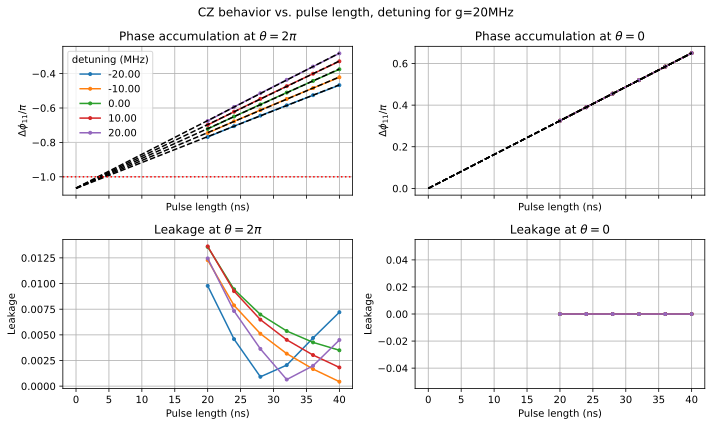

In [15]:
# plot phi_11 and leakage side by side

fig, axes_grid = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

ax = axes_grid[:, 1]
ax[0].plot(tgvec, np.unwrap(phi_11_arr[:, :, 0])/np.pi, '.-')
for i in range(phifit_0.shape[1]):
    ax[0].plot(t_extrap, np.polyval(phifit_0[:, i], t_extrap)/np.pi, 'k--')
ax[0].grid(which='both')
ax[0].set_xlabel('Pulse length (ns)')
ax[0].set_ylabel(r'$\Delta\phi_{11}/\pi$')
ax[0].set_title(r'Phase accumulation at $\theta=0$')
ax[1].plot(tgvec, leakage_arr[:, :, 0], '.-')
ax[1].grid(which='both')
ax[1].set_xlabel('Pulse length (ns)')
ax[1].set_title(r'Leakage at $\theta=0$')
ax[1].set_ylabel('Leakage')

ax = axes_grid[:, 0]
ax[0].plot(tgvec, np.unwrap(phi_11_arr[:, :, 1])/np.pi, '.-')
for i in range(phifit_2pi.shape[1]):
    ax[0].plot(t_extrap, np.polyval(phifit_2pi[:, i], t_extrap)/np.pi, 'k--')
ax[0].axhline(-1, color='r', linestyle=':')
ax[0].grid(which='both')
ax[0].set_xlabel('Pulse length (ns)')
ax[0].set_ylabel(r'$\Delta\phi_{11}/\pi$')
ax[0].set_title(r'Phase accumulation at $\theta=2\pi$')
ax[0].legend([f'{d*1e3:.2f}' for d in detuning_vec], title='detuning (MHz)')
ax[1].plot(tgvec, leakage_arr[:, :, 1], '.-')
ax[1].grid(which='both')
ax[1].set_xlabel('Pulse length (ns)')
ax[1].set_title(r'Leakage at $\theta=2\pi$')
ax[1].set_ylabel('Leakage')

fig.suptitle('CZ behavior vs. pulse length, detuning for g=20MHz')
fig.tight_layout()

## retrying with more reasonable parameters

in the previous example we've seen that the static shift it too large, and the gate duration needed to apply the gate is very short. Here we try to fix this by going to a lower interaction strength, 5MHz instead of 20MHz.



In [16]:
g_strength = 0.005
tmon1, tmon2, hilbertspace = generate_hilbertspace(21, 0.25, 27, 0.25, g_strength)

summarize_parameters(tmon1, tmon2, hilbertspace)

n_1, n_2, interaction_term = generate_interaction_terms(tmon1, tmon2, hilbertspace, g_strength)

tgvec = np.linspace(20, 40, 6)
detuning_vec = np.linspace(-g_strength, g_strength, 5)
rot_angle_vec = np.array([0, 2*np.pi])

drive_term = interaction_term
transitions = [(1, 1), (0, 2)]

phi_11_arr = []
leakage_arr = []
for detuning in detuning_vec:
    phi_11_arr.append([])
    leakage_arr.append([])
    for tg in tqdm(tgvec):
        leakage_arr[-1].append([])
        phi_11_arr[-1].append([])
        for rot_angle in rot_angle_vec:

            # print(f'{tg=:.3f} ns')
            H_qbt_drive = get_drive_hamiltonian(drive_term, transitions, tg, detuning=detuning, rot_angle=rot_angle)

            prop, Ucprime, phi_11, leakage = calc_prop_ucprime(H_qbt_drive, tg)
            phi_11_arr[-1][-1].append(phi_11)
            leakage_arr[-1][-1].append(leakage)

leakage_arr = np.array(leakage_arr).transpose(1, 0, 2)
phi_11_arr = np.array(phi_11_arr).transpose(1, 0, 2)

# extrapolate to tg = 0 using polyfit

phifit_0 = np.polyfit(tgvec, np.unwrap(phi_11_arr[:, :, 0]), 1)
phifit_2pi = np.polyfit(tgvec, np.unwrap(phi_11_arr[:, :, 1]), 1)
t_extrap = np.linspace(0, 40, 100)

bare parameters
----------------
tmon1 anharmonicity = -0.2766 GHz
tmon2 anharmonicity = -0.2728 GHz
tmon1 E01 = 6.2200 GHz
tmon2 E01 = 7.0891 GHz
tmon1 E01 - tmon2 E01 = 0.8691 GHz

dressed parameters (g = 5.00 MHz)
------------------------------
f00_10=6.220 GHz
f00_01=7.089 GHz
f11_20=-1.146 GHz
f11_02=0.597 GHz
static ZZ = -0.106692 MHz
E10 shift = 0.0841 MHz
E01 shift = -0.0742 MHz


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


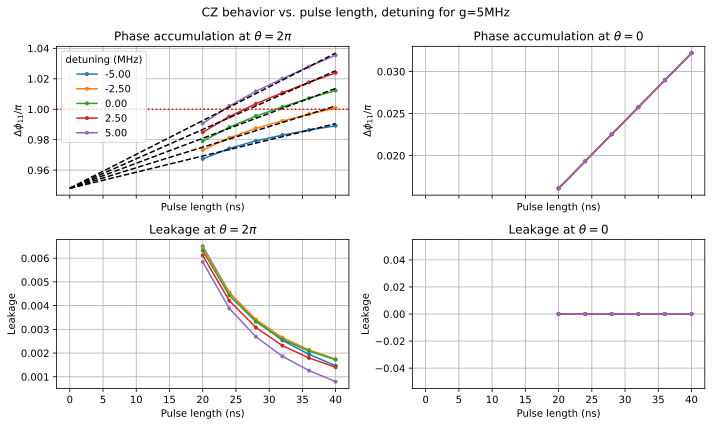

In [17]:
# plot phi_11 and leakage side by side

fig, axes_grid = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
ax = axes_grid[:, 1]
ax[0].plot(tgvec, np.unwrap(phi_11_arr[:, :, 0])/np.pi, '.-')
ax[0].grid(which='both')
ax[0].set_xlabel('Pulse length (ns)')
ax[0].set_ylabel(r'$\Delta\phi_{11}/\pi$')
ax[0].set_title(r'Phase accumulation at $\theta=0$')
ax[1].plot(tgvec, leakage_arr[:, :, 0], '.-')
ax[1].grid(which='both')
ax[1].set_xlabel('Pulse length (ns)')
ax[1].set_title(r'Leakage at $\theta=0$')
ax[1].set_ylabel('Leakage')

ax = axes_grid[:, 0]
ax[0].plot(tgvec, np.unwrap(phi_11_arr[:, :, 1])/np.pi, '.-')
for i in range(phifit_2pi.shape[1]):
    ax[0].plot(t_extrap, np.polyval(phifit_2pi[:, i], t_extrap)/np.pi, 'k--')
ax[0].grid(which='both')
ax[0].legend([f'{d*1e3:.2f}' for d in detuning_vec], title='detuning (MHz)')
ax[0].set_xlabel('Pulse length (ns)')
ax[0].set_ylabel(r'$\Delta\phi_{11}/\pi$')
ax[0].set_title(r'Phase accumulation at $\theta=2\pi$')
ax[0].axhline(1, color='r', linestyle=':')
ax[1].plot(tgvec, leakage_arr[:, :, 1], '.-')
ax[1].grid(which='both')
ax[1].set_xlabel('Pulse length (ns)')
ax[1].set_title(r'Leakage at $\theta=2\pi$')
ax[1].set_ylabel('Leakage')

fig.suptitle('CZ behavior vs. pulse length, detuning for g=5MHz')
fig.tight_layout()

### Obtaining the unitary with optimal parameters

Out of the detuning values we chose, we see we get the lowest leakage for positive detuning of 5MHz. Let's find the optimal time for this detuning and show the resulting unitary:

Optimal pulse length = 23.21 ns


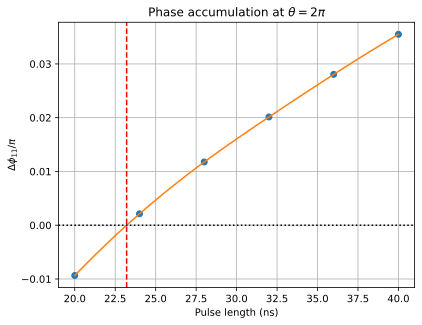

In [18]:
y_opt = np.unwrap(phi_11_arr[:, -1, 1])/np.pi
x = tgvec
# find the optimal pulse length by interpolating y_opt and finding the zero crossing
from scipy.interpolate import interp1d
f = interp1d(x, y_opt-1, kind='cubic')
xnew = np.linspace(x[0], x[-1], 1000)
ynew = f(xnew)
plt.plot(x, y_opt-1, 'o', xnew, ynew, '-')
plt.grid(which='both')
plt.xlabel('Pulse length (ns)')
plt.ylabel(r'$\Delta\phi_{11}/\pi$')
plt.title(r'Phase accumulation at $\theta=2\pi$')

plt.axhline(0, color='k', linestyle=':')

from scipy.optimize import fsolve
# find the zero crossing
zero_crossing = fsolve(f, 30)
print(f'Optimal pulse length = {zero_crossing[0]:.2f} ns')
plt.axvline(zero_crossing, color='r', linestyle='--')

plt.show()

# print(f'{tg=:.3f} ns')
H_qbt_drive = get_drive_hamiltonian(drive_term, transitions, zero_crossing, detuning=0.005, rot_angle=2*np.pi)

prop, Ucprime, phi_11, leakage = calc_prop_ucprime(H_qbt_drive, tg)


And here is the CZ unitary:

In [19]:
Ucprime

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -2.74419485e-07+1.34781684e-06j]
 [ 0.00000000e+00+0.00000000e+00j  9.99999998e-01+0.00000000e+00j
  -5.54171683e-05+8.61527666e-06j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  5.54145185e-05+8.56069647e-06j
   9.99999998e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 7.41374451e-07-1.83863026e-06j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -9.99156431e-01-4.08509368e-02j]]